# Training a language model with RNNs

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import os

## Data wikitext-2
The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia.

The data can be dowloaded here.
`https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip`

In [35]:
PATH=Path("/data/yinterian/wikitext-2")
list(PATH.iterdir())

[PosixPath('/data/yinterian/wikitext-2/wiki.train.tokens'),
 PosixPath('/data/yinterian/wikitext-2/wiki.valid.tokens'),
 PosixPath('/data/yinterian/wikitext-2/wiki.test.tokens')]

In [36]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)


class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        self.train = self.tokenize(os.path.join(path, 'wiki.train.tokens'))
        self.valid = self.tokenize(os.path.join(path, 'wiki.valid.tokens'))
        self.test = self.tokenize(os.path.join(path, 'wiki.test.tokens'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r') as f:
            tokens = 0
            for line in f:
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r') as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1
        return ids

In [37]:
corpus = Corpus(PATH)
len(corpus.dictionary)

33278

In [39]:
def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.cuda()

In [40]:
batch_size = 20
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, batch_size)
test_data = batchify(corpus.test, batch_size)

In [77]:
len(train_data)

104431

## Model
Based on the model [here](https://github.com/pytorch/examples/tree/master/word_language_model)

In [42]:
class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.GRU(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        init_range = 0.1
        self.encoder.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.fill_(0.0)
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return Variable(weight.new(self.nlayers, bsz, self.nhid).zero_())

## Get a batch of data

In [79]:
def get_batch(source, i, bptt, evaluation=False):
    seq_len = min(bptt, len(source) - 1 - i)
    data = Variable(source[i:i+seq_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+seq_len].view(-1))
    return data, target

In [97]:
x, y = get_batch(train_data, 0, 35)
print(x.data.shape, y.data.shape)

torch.Size([35, 20]) torch.Size([700])


In [95]:
x[0,:], y[0]

(Variable containing:
      0
    284
  15178
    280
    348
    128
    289
   9493
     16
      1
     13
      0
   2701
   1227
   1563
   4044
    115
   1352
   1335
     16
 [torch.cuda.LongTensor of size 20 (GPU 0)], Variable containing:
  1
 [torch.cuda.LongTensor of size 1 (GPU 0)])

## Learning rate finder

In [108]:
def batchify2(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.cuda()

In [115]:
data = torch.LongTensor(list(range(2005)))
d = batchify2(data, 20)
d.size()

torch.Size([100, 20])

In [116]:
def get_batch(source, i, bptt, evaluation=False):
    seq_len = min(bptt, len(source) - 1 - i)
    data = Variable(source[i:i+seq_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+seq_len].view(-1))
    return data, target

In [119]:
x, y = get_batch(d, i=0, bptt=15)
x.data.shape

torch.Size([15, 20])

In [122]:
len(x)

15

In [128]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_data, lr_low=1e-3, lr_high=10, epochs=2):
    losses = []
    (train_data.size(0) - 1)//bptt + 1
    iterations = epochs * ((train_data.size(0) - 1)//bptt + 1)
    delta = (lr_high - lr_low)/(iterations-1)
    losses = []
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    total_loss = 0
    ntokens = len(corpus.dictionary)
    for i in range(epochs):
        hidden = model.init_hidden(batch_size)
        for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
            lr = lrs[ind]
            data, targets = get_batch(train_data, i, bptt)
        
            hidden = Variable(hidden.data) #.detach()
            model.zero_grad()
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, ntokens), targets)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            losses.append(loss.data[0])
            ind += 1
    return lrs, losses 

In [129]:
nemb = 300
nhid = 300
nlayers = 2
ntokens = len(corpus.dictionary)
model = RNNModel(ntokens, nemb, nhid, nlayers).cuda()
lrs, losses = LR_range_finder(model, train_data)

In [126]:
len(lrs)

5968

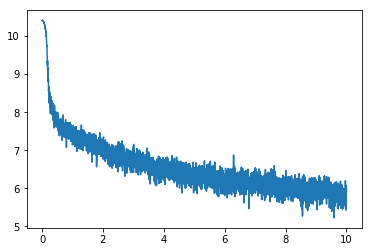

In [130]:
import matplotlib.pyplot as plt 
plt.plot(lrs, losses)
plt.show()

In [132]:
def get_triangular_lr2(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

## Training

In [43]:
criterion = nn.CrossEntropyLoss()

In [44]:
def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = len(corpus.dictionary)
    hidden = model.init_hidden(batch_size)
    for i in range(0, data_source.size(0) - 1, bptt):
        data, targets = get_batch(data_source, i, bptt, evaluation=True)
        output, hidden = model(data, hidden)
        output_flat = output.view(-1, ntokens)
        total_loss += len(data) * criterion(output_flat, targets).data
        hidden = Variable(hidden.data) #.detach()
    return total_loss[0] / len(data_source)

In [45]:
def repackage_hidden(h):
    """Wraps hidden states in new Variables, to detach them from their history."""
    return Variable(h.data)

In [146]:
import time
import math
bptt = 35
clip = 0.25

def get_batch(source, i, bptt, evaluation=False):
    seq_len = min(bptt, len(source) - 1 - i)
    data = Variable(source[i:i+seq_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+seq_len].view(-1))
    return data, target
    
def train_triangular_policy(model, epochs=4, lr_low=1e-4, lr_high=4):
    # Turn on training mode which enables dropout.
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    iterations = epochs * ((train_data.size(0) - 1)//bptt + 1)
    lrs = get_triangular_lr2(lr_low, lr_high, iterations)
    idx = 0
    for epoch in range(epochs):
        total_loss = 0
        model.train()
        start_time = time.time()
        hidden = model.init_hidden(batch_size)
        for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
            lr = lrs[idx]
            data, targets = get_batch(train_data, i, bptt)
            # Starting each batch, we detach the hidden state from how it was previously produced.
            # If we didn't, the model would try backpropagating all the way to start of the dataset.
            hidden = Variable(hidden.data) #.detach()
            model.zero_grad()
            output, hidden = model(data, hidden)
            loss = criterion(output.view(-1, ntokens), targets)
            loss.backward()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)
            for p in model.parameters():
                p.data.add_(-lr, p.grad.data)

            total_loss += len(data)*loss.data
            idx += 1
        # results after each epoch
        val_loss = evaluate(val_data)
        elapsed = time.time() - start_time
        train_loss = total_loss[0]/len(train_data)
        print('| epoch {:3d} | lr {:02.5f} | t_loss {:5.2f} | t_ppl {:5.2f} | v_loss {:5.2f} | v_ppl {:5.2f}'.format(
             epoch, lr, train_loss, math.exp(train_loss), val_loss, math.exp(val_loss)))

In [147]:
steps = 10
nemb = 300
nhid = 300
nlayers = 2
ntokens = len(corpus.dictionary)
model = RNNModel(ntokens, nemb, nhid, nlayers).cuda()

In [148]:
train_triangular_policy(model, epochs=4, lr_low=4, lr_high=10)

| epoch   0 | lr 8.28489 | t_loss  6.51 | t_ppl 674.11 | v_loss  5.87 | v_ppl 354.31
| epoch   1 | lr 7.42878 | t_loss  5.81 | t_ppl 333.00 | v_loss  5.47 | v_ppl 237.30
| epoch   2 | lr 4.63954 | t_loss  5.47 | t_ppl 237.08 | v_loss  5.28 | v_ppl 196.77
| epoch   3 | lr 4.00000 | t_loss  5.30 | t_ppl 200.27 | v_loss  5.20 | v_ppl 180.44


In [149]:
train_triangular_policy(model, epochs=4, lr_low=4, lr_high=10)

| epoch   0 | lr 8.28489 | t_loss  5.23 | t_ppl 185.87 | v_loss  5.27 | v_ppl 195.36
| epoch   1 | lr 7.42878 | t_loss  5.21 | t_ppl 182.71 | v_loss  5.14 | v_ppl 170.18
| epoch   2 | lr 4.63954 | t_loss  5.05 | t_ppl 155.47 | v_loss  5.05 | v_ppl 155.32
| epoch   3 | lr 4.00000 | t_loss  4.95 | t_ppl 140.87 | v_loss  5.02 | v_ppl 150.83


In [150]:
train_triangular_policy(model, epochs=4, lr_low=2, lr_high=8)

| epoch   0 | lr 6.28489 | t_loss  4.89 | t_ppl 132.78 | v_loss  5.05 | v_ppl 155.79
| epoch   1 | lr 5.42878 | t_loss  4.92 | t_ppl 136.97 | v_loss  5.00 | v_ppl 148.77
| epoch   2 | lr 2.63954 | t_loss  4.81 | t_ppl 122.94 | v_loss  4.93 | v_ppl 138.66
| epoch   3 | lr 2.00000 | t_loss  4.74 | t_ppl 114.89 | v_loss  4.91 | v_ppl 135.16


In [151]:
train_triangular_policy(model, epochs=4, lr_low=1, lr_high=6)

| epoch   0 | lr 4.57074 | t_loss  4.72 | t_ppl 111.93 | v_loss  4.94 | v_ppl 139.20
| epoch   1 | lr 3.85731 | t_loss  4.75 | t_ppl 115.95 | v_loss  4.92 | v_ppl 136.52
| epoch   2 | lr 1.53295 | t_loss  4.68 | t_ppl 107.79 | v_loss  4.87 | v_ppl 130.26
| epoch   3 | lr 1.00000 | t_loss  4.64 | t_ppl 103.23 | v_loss  4.86 | v_ppl 128.61


In [152]:
train_triangular_policy(model, epochs=4, lr_low=1, lr_high=6)

| epoch   0 | lr 4.57074 | t_loss  4.63 | t_ppl 102.67 | v_loss  4.92 | v_ppl 137.39
| epoch   1 | lr 3.85731 | t_loss  4.68 | t_ppl 107.87 | v_loss  4.90 | v_ppl 134.66
| epoch   2 | lr 1.53295 | t_loss  4.61 | t_ppl 100.48 | v_loss  4.85 | v_ppl 128.21
| epoch   3 | lr 1.00000 | t_loss  4.57 | t_ppl 96.35 | v_loss  4.84 | v_ppl 126.53


In [153]:
train_triangular_policy(model, epochs=4, lr_low=1, lr_high=6)

| epoch   0 | lr 4.57074 | t_loss  4.56 | t_ppl 96.05 | v_loss  4.89 | v_ppl 133.27
| epoch   1 | lr 3.85731 | t_loss  4.62 | t_ppl 101.44 | v_loss  4.89 | v_ppl 132.65
| epoch   2 | lr 1.53295 | t_loss  4.55 | t_ppl 94.80 | v_loss  4.84 | v_ppl 126.95
| epoch   3 | lr 1.00000 | t_loss  4.51 | t_ppl 90.96 | v_loss  4.82 | v_ppl 124.18


In [154]:
train_triangular_policy(model, epochs=4, lr_low=0.5, lr_high=4)

| epoch   0 | lr 2.99952 | t_loss  4.50 | t_ppl 89.74 | v_loss  4.86 | v_ppl 129.32
| epoch   1 | lr 2.50012 | t_loss  4.53 | t_ppl 92.43 | v_loss  4.84 | v_ppl 127.01
| epoch   2 | lr 0.87306 | t_loss  4.49 | t_ppl 89.01 | v_loss  4.82 | v_ppl 123.92
| epoch   3 | lr 0.50000 | t_loss  4.47 | t_ppl 87.05 | v_loss  4.81 | v_ppl 122.50


In [155]:
train_triangular_policy(model, epochs=4, lr_low=0.01, lr_high=4)

| epoch   0 | lr 2.85945 | t_loss  4.46 | t_ppl 86.56 | v_loss  4.85 | v_ppl 127.17
| epoch   1 | lr 2.29014 | t_loss  4.49 | t_ppl 89.35 | v_loss  4.84 | v_ppl 126.69
| epoch   2 | lr 0.43529 | t_loss  4.46 | t_ppl 86.33 | v_loss  4.80 | v_ppl 121.29
| epoch   3 | lr 0.01000 | t_loss  4.47 | t_ppl 87.38 | v_loss  4.77 | v_ppl 118.18


In [156]:
train_triangular_policy(model, epochs=4, lr_low=0.01, lr_high=3)

| epoch   0 | lr 2.14531 | t_loss  4.43 | t_ppl 84.30 | v_loss  4.83 | v_ppl 125.45
| epoch   1 | lr 1.71867 | t_loss  4.45 | t_ppl 85.35 | v_loss  4.82 | v_ppl 124.22
| epoch   2 | lr 0.32870 | t_loss  4.43 | t_ppl 83.84 | v_loss  4.79 | v_ppl 120.38
| epoch   3 | lr 0.01000 | t_loss  4.45 | t_ppl 85.78 | v_loss  4.77 | v_ppl 117.60


In [ ]:
train_triangular_policy(model, epochs=4, lr_low=0.001, lr_high=2)

| epoch   0 | lr 1.42858 | t_loss  4.40 | t_ppl 81.53 | v_loss  4.81 | v_ppl 122.89


In [ ]:
p = PATH/"mode117.pth"
save_model(model, p)

## References
* https://github.com/pytorch/examples/tree/master/word_language_model
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/